# Mammogram classifier

## Project's goal

Predict whether a mammogram mass is benign or malignant. 

## Data

The data used for this project comes from the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass). 

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:

1. BI-RADS assessment (ordinal) - 1 to 5 
2. Age (integer) - Patient's age in years 
3. Mass shape (nominal)- Mass shape: round=1 oval=2 lobular=3 irregular=4 
4. Mass margin (nominal) - circumscribed=1; micro-lobulated=2; obscured=3; ill-defined=4; spiculated=5
5. Mass density (ordinal) - high=1; iso=2; low=3; fat-containing=4 
6. Severity (binomial) - benign=0 or malignant=1

## Methodology

Data pre-processing:

* Data exploration
* Handling missing data 
* Feature selection 
* Normalization 

Apply several different supervised machine learning techniques and see which one yields the highest accuracy.

Models tested:

* Logistic Regression 
* KNN
* Naive Bayes
* Decision Tree
* Random Forest
* SVM
* Neural network

Models are tested using K-fold cross validation (K=10). 

## Data pre-processing

In [131]:
import pandas as pd

data = pd.read_csv('mammographic_masses.data.txt')
data.head()

,5,67,3,5.1,3.1,1
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,?,1
4,4,65,1,?,3,0


Load data converting missing data (indicated by "?") into NaN values and add appropriate column names. 

In [132]:
data = pd.read_csv('mammographic_masses.data.txt', na_values=['?'], names = ['BI-RADS', 'age', 'shape', 'margin', 'density', 'severity'])
data.head()

,BI-RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [133]:
# Data exploration

data.describe()

,BI-RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Let's look at the missing values. 

In [134]:
data.loc[(data['age'].isnull()) |
        (data['shape'].isnull()) |
        (data['margin'].isnull()) |
        (data['density'].isnull())]

,BI-RADS,age,shape,margin,density,severity
1,4.0,43.0,1.0,1.0,NaN,1
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...,...
778,4.0,60.0,NaN,4.0,3.0,0
819,4.0,35.0,3.0,NaN,2.0,0
824,6.0,40.0,NaN,3.0,4.0,1
884,5.0,NaN,4.0,4.0,3.0,1


Check if the missing data is randomly distributed or if it appears there's any sort of correlation.

18.0    1
19.0    4
20.0    1
21.0    6
22.0    3
       ..
86.0    5
87.0    5
88.0    1
93.0    1
96.0    1
Name: age, Length: 73, dtype: int64


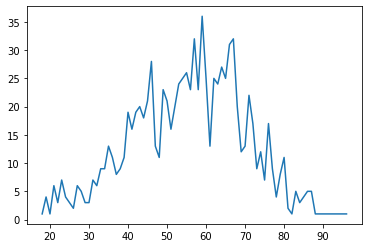

In [135]:
attribute = "age"    # check every attribute
distribution = data[attribute].value_counts().sort_index()
print(distribution)

import matplotlib.pyplot as plt
X = distribution.index
Y = distribution.values
plt.plot(X,Y)

Missing data seems randomly distributed. We can move on and drop rows containing missing values. 

In [136]:
data.dropna(inplace=True)
data.describe()

,BI-RADS,age,shape,margin,density,severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Dropping missing values reduces our dataset from 961 to 830 instances which is reasonable.

Now, let's convert the dataframe into NumPy arrays that can be used by scikit-learn :
* An array X containing data of predictive features (age, shape, margin and density). The attribute BI-RADS (assessment of how confident the severity classfication is) is dropped because it is not a "predictive" attribute. 
* An array Y containing classification data (severity).

N.B: No need of creating Train/Test datasets, we will directly use K-fold cross validation to increase performances reliability and avoid overfitting. 

In [137]:
feature_names = ['age', 'shape', 'margin', 'density']
X = data[feature_names].values
Y = data['severity'].values

X

array([[67.,  3.,  5.,  3.],
       [58.,  4.,  5.,  3.],
       [28.,  1.,  1.,  3.],
       ...,
       [64.,  4.,  5.,  3.],
       [66.,  4.,  5.,  3.],
       [62.,  3.,  3.,  3.]])

Normalization step - some models require the input data to be normalized. 

In [138]:
# Input data normalization

from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.7650629 ,  0.17563638,  1.39618483,  0.24046607],
       [ 0.15127063,  0.98104077,  1.39618483,  0.24046607],
       [-1.89470363, -1.43517241, -1.157718  ,  0.24046607],
       ...,
       [ 0.56046548,  0.98104077,  1.39618483,  0.24046607],
       [ 0.69686376,  0.98104077,  1.39618483,  0.24046607],
       [ 0.42406719,  0.17563638,  0.11923341,  0.24046607]])

# Logistic Regression

In [139]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
cv_scores = cross_val_score(model, X_scaled, Y, cv=10)
score = cv_scores.mean()

# Save score in a scores matrix
scores = pd.DataFrame(columns=['Model', 'Score'])
scores.loc[0] = ['Logistic Regression', score]
scores

,Model,Score
0,Logistic Regression,0.807229


# KNN

In [140]:
from sklearn import neighbors

# Try with K ranging from 1 to 50 
results = pd.DataFrame(columns=['K value', 'Score'])
for k in range(1, 50):
    model = neighbors.KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(model, X_scaled, Y, cv=10)
    results.loc[k] = [int(k), cv_scores.mean()]
    
results = results.sort_values('Score', ascending=False)
results.reset_index(drop=True)

,K value,Score
0,7.0,0.795181
1,49.0,0.791566
2,10.0,0.791566
3,9.0,0.790361
4,48.0,0.790361
5,30.0,0.790361
6,11.0,0.789157
7,47.0,0.789157
8,32.0,0.789157
9,13.0,0.787952


In [141]:
# K=7 achieve a score around 0.795. K=9,10 and 11 have also good performances (around 0,79)

scores.loc[1] = ['KNN', results['Score'].iloc[0]]
scores

,Model,Score
0,Logistic Regression,0.807229
1,KNN,0.795181


# Naive Bayes

In [142]:
from sklearn.naive_bayes import MultinomialNB

scaler = preprocessing.MinMaxScaler()
X_minmax = scaler.fit_transform(X)

model = MultinomialNB()
cv_scores = cross_val_score(model, X_minmax, Y, cv=10)

score = cv_scores.mean()

scores.loc[2] = ['Naive Bayes', score]
scores

,Model,Score
0,Logistic Regression,0.807229
1,KNN,0.795181
2,Naive Bayes,0.785542


# Decision Tree

In [143]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=1)
cv_scores = cross_val_score(model, X_scaled, Y, cv=10)
score = cv_scores.mean()

scores.loc[3] = ['Decision Tree', score]
scores

,Model,Score
0,Logistic Regression,0.807229
1,KNN,0.795181
2,Naive Bayes,0.785542
3,Decision Tree,0.737349


# Random Forest 

In [144]:
from sklearn.ensemble import RandomForestClassifier

results = pd.DataFrame(columns=['n_estimators', 'Score'])
k = 0
for n_estimators in range(5, 21):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=1)
    cv_scores = cross_val_score(model, X_scaled, Y, cv=10)
    results.loc[k] = [n_estimators, cv_scores.mean()]
    k += 1
    
results = results.sort_values('Score', ascending=False)
results.reset_index(drop=True)

,n_estimators,Score
0,19.0,0.759036
1,14.0,0.757831
2,18.0,0.757831
3,17.0,0.756627
4,20.0,0.756627
5,13.0,0.755422
6,15.0,0.754217
7,9.0,0.750602
8,11.0,0.749398
9,12.0,0.745783


In [145]:
scores.loc[4] = ['Random Forest', results['Score'].iloc[0]]
scores

,Model,Score
0,Logistic Regression,0.807229
1,KNN,0.795181
2,Naive Bayes,0.785542
3,Decision Tree,0.737349
4,Random Forest,0.759036


# SVM

In [146]:
from sklearn import svm

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = pd.DataFrame(columns=['Kernel', 'Score'])
k = 0
for kernel in kernels:
    model = svm.SVC(kernel='linear', C=1.0)
    cv_scores = cross_val_score(model, X_scaled, Y, cv=10)
    results.loc[k] = [kernel, cv_scores.mean()]
    k += 1
    
results

,Kernel,Score
0,linear,0.79759
1,poly,0.79759
2,rbf,0.79759
3,sigmoid,0.79759


In [147]:
scores.loc[5] = ['SVM', 0.79759]
scores

,Model,Score
0,Logistic Regression,0.807229
1,KNN,0.795181
2,Naive Bayes,0.785542
3,Decision Tree,0.737349
4,Random Forest,0.759036
5,SVM,0.797590


# Neural Network 

In [150]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

def create_model():
    model = Sequential()
    # Input Layer - 4 feature inputs into a 6-unit layer 
    model.add(Dense(4, input_dim=4, kernel_initializer='normal', activation='relu'))
    # Hidden layer 1 (turns out to be inefficient)
    #model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    # Output layer - single neuron layer with sigmoid activation (binary classification)
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [151]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Wrap Keras model in an estimator compatible with scikit_learn
estimator = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)

# Use scikit_learn's cross_val_score to evaluate performances
cv_scores = cross_val_score(estimator, X_scaled, Y, cv=10)
score = cv_scores.mean()

scores.loc[6] = ['Neural Network', score]
scores

,Model,Score
0,Logistic Regression,0.807229
1,KNN,0.795181
2,Naive Bayes,0.785542
3,Decision Tree,0.737349
4,Random Forest,0.759036
5,SVM,0.797590
6,Neural Network,0.804819
